In [131]:
# Problem Statement: Build Movie Recommendation Engine
# Input data: Movielens dataset
# Output result: Recommend movies based on User behaviour
# Machine learning algorithm: XGBoost
# Evaluation metric: RMSE
# Programming language: Python
# Author: Thirupathi Jadi
# Designation: Lead Data Scientist

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error


import xgboost as xgb
from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV

## Reading and Storing Data

### Data Pre-processing

In [7]:
if not os.path.isfile("/home/jadi/jadi/assignments/emaar/data1/movielens/NetflixRatings.csv"): 
#This line: "os.path.isfile("../Data/NetflixRatings.csv")" simply checks that is there a file with the name "NetflixRatings.csv" in the 
#in the folder "/Data/". If the file is present then it return true else false
    startTime = datetime.now()
    data = open("/home/jadi/jadi/assignments/emaar/data1/movielens/NetflixRatings.csv", mode = "w") #this line simply creates the file with the name "NetflixRatings.csv" in 
    #write mode in the folder "Data".
#     files = ['/home/jadi/jadi/assignments/emaar/data1/movielens/combined_data_1.txt','/home/jadi/jadi/assignments/emaar/data1/movielens/combined_data_2.txt', '/home/jadi/jadi/assignments/emaar/data1/movielens/combined_data_3.txt', '/home/jadi/jadi/assignments/emaar/data1/movielens/combined_data_4.txt']
#     files = ['/home/jadi/jadi/assignments/emaar/data1/movielens/combined_data_2.txt', '/home/jadi/jadi/assignments/emaar/data1/movielens/combined_data_4.txt']
    files = ['/home/jadi/jadi/assignments/emaar/data1/movielens/combined_data_2.txt']
    for file in files:
        print("Reading from file: "+str(file)+"...")
        with open(file) as f:  #you can think of this command "with open(file) as f" as similar to 'if' statement or a sort of 
            #loop statement. This command says that as long as this file is opened, perform the underneath operation.
            for line in f:
                line = line.strip() #line.strip() clears all the leading and trailing spaces from the string, as here each line
                #that we are reading from a file is a string.
                #Note first line consist of a movie id followed by a semi-colon, then second line contains custID,rating,date
                #then third line agains contains custID,rating,date which belong to that movie ID and so on. The format of data
                #is exactly same as shown above with the heading "Example Data Point". Check out above.
                if line.endswith(":"):
                    movieID = line.replace(":", "") #this will remove the trailing semi-colon and return us the leading movie ID.
                else:
                    #here, in the below code we have first created an empty list with the name "row "so that we can insert movie ID 
                    #at the first position and rest customerID, rating and date in second position. After that we have separated all 
                    #four namely movieID, custID, rating and date with comma and converted a single string by joining them with comma.
                    #then finally written them to our output ".csv" file.
                    row = [] 
                    row = [x for x in line.split(",")] #custID, rating and date are separated by comma
                    row.insert(0, movieID)
                    data.write(",".join(row))
                    data.write("\n")
        print("Reading of file: "+str(file)+" is completed\n")
    data.close()
    print("Total time taken for execution of this code = "+str(datetime.now() - startTime))

Reading from file: /home/jadi/jadi/assignments/emaar/data1/movielens/combined_data_2.txt...
Reading of file: /home/jadi/jadi/assignments/emaar/data1/movielens/combined_data_2.txt is completed

Total time taken for execution of this code = 0:00:48.259727


In [8]:
# creating data frame from our output csv file.
if not os.path.isfile("/home/jadi/jadi/assignments/emaar/data1/movielens/NetflixData.pkl"):
    startTime = datetime.now()
    Final_Data = pd.read_csv("/home/jadi/jadi/assignments/emaar/data1/movielens/NetflixRatings.csv", sep=",", names = ["MovieID","CustID", "Ratings", "Date"])
    Final_Data["Date"] = pd.to_datetime(Final_Data["Date"])
    Final_Data.sort_values(by = "Date", inplace = True)
    print("Time taken for execution of above code = "+str(datetime.now() - startTime))

Time taken for execution of above code = 0:00:18.256506


In [9]:
# storing pandas dataframe as a picklefile for later use
if not os.path.isfile("/home/jadi/jadi/assignments/emaar/data1/movielens/NetflixData.pkl"):
    Final_Data.to_pickle("/home/jadi/jadi/assignments/emaar/data1/movielens/NetflixData.pkl")
else:
    Final_Data = pd.read_pickle("/home/jadi/jadi/assignments/emaar/data1/movielens/NetflixData.pkl")

In [10]:
Final_Data.head()

,MovieID,CustID,Ratings,Date
6465113,5571,510180,4,1999-11-11
21262258,8079,510180,2,1999-11-11
13151644,6615,510180,5,1999-11-11
24047847,8651,510180,2,1999-11-11
22463125,8357,510180,4,1999-11-11


In [11]:
Final_Data.describe()["Ratings"]

count    2.697759e+07
mean     3.589280e+00
std      1.084677e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: Ratings, dtype: float64

### Checking for NaN

In [12]:
print("Number of NaN values = "+str(Final_Data.isnull().sum()))

Number of NaN values = MovieID    0
CustID     0
Ratings    0
Date       0
dtype: int64


### Removing Duplicates

In [13]:
duplicates = Final_Data.duplicated(["MovieID","CustID", "Ratings"])
print("Number of duplicate rows = "+str(duplicates.sum()))

Number of duplicate rows = 0


### Basic Statistics

In [14]:
print("Total Data:")
print("Total number of movie ratings = "+str(Final_Data.shape[0]))
print("Number of unique users = "+str(len(np.unique(Final_Data["CustID"]))))
print("Number of unique movies = "+str(len(np.unique(Final_Data["MovieID"]))))

Total Data:
Total number of movie ratings = 26977591
Number of unique users = 474062
Number of unique movies = 4711


### Spliting data into Train and Test(80:20)

In [15]:
if not os.path.isfile("/home/jadi/jadi/assignments/emaar/data1/movielens/TrainData.pkl"):
    Final_Data.iloc[:int(Final_Data.shape[0]*0.80)].to_pickle("/home/jadi/jadi/assignments/emaar/data1/movielens/TrainData.pkl")
    Train_Data = pd.read_pickle("/home/jadi/jadi/assignments/emaar/data1/movielens/TrainData.pkl")
    Train_Data.reset_index(drop = True, inplace = True)
else:
    Train_Data = pd.read_pickle("/home/jadi/jadi/assignments/emaar/data1/movielens/TrainData.pkl")
    Train_Data.reset_index(drop = True, inplace = True)

if not os.path.isfile("/home/jadi/jadi/assignments/emaar/data1/movielens/TestData.pkl"):
    Final_Data.iloc[int(Final_Data.shape[0]*0.80):].to_pickle("/home/jadi/jadi/assignments/emaar/data1/movielens/TestData.pkl")
    Test_Data = pd.read_pickle("/home/jadi/jadi/assignments/emaar/data1/movielens/TestData.pkl")
    Test_Data.reset_index(drop = True, inplace = True)
else:
    Test_Data = pd.read_pickle("/home/jadi/jadi/assignments/emaar/data1/movielens/TestData.pkl")
    Test_Data.reset_index(drop = True, inplace = True)

### Basic Statistics in Train data

In [16]:
Train_Data.head()

,MovieID,CustID,Ratings,Date
0,5571,510180,4,1999-11-11
1,8079,510180,2,1999-11-11
2,6615,510180,5,1999-11-11
3,8651,510180,2,1999-11-11
4,8357,510180,4,1999-11-11


In [17]:
print("Total Train Data:")
print("Total number of movie ratings in train data = "+str(Train_Data.shape[0]))
print("Number of unique users in train data = "+str(len(np.unique(Train_Data["CustID"]))))
print("Number of unique movies in train data = "+str(len(np.unique(Train_Data["MovieID"]))))
print("Highest value of a User ID = "+str(max(Train_Data["CustID"].values)))
print("Highest value of a Movie ID = "+str(max(Train_Data["MovieID"].values)))

Total Train Data:
Total number of movie ratings in train data = 21582072
Number of unique users in train data = 393933
Number of unique movies in train data = 4605
Highest value of a User ID = 2649429
Highest value of a Movie ID = 9210


### Basic Statistics in Test data

In [18]:
Test_Data.head()

,MovieID,CustID,Ratings,Date
0,7870,1530932,2,2005-08-07
1,7249,257923,3,2005-08-07
2,5496,2073514,3,2005-08-07
3,8736,2329026,4,2005-08-07
4,6428,938651,4,2005-08-07


In [19]:
print("Total Test Data:")
print("Total number of movie ratings in Test data = "+str(Test_Data.shape[0]))
print("Number of unique users in Test data = "+str(len(np.unique(Test_Data["CustID"]))))
print("Number of unique movies in Test data = "+str(len(np.unique(Test_Data["MovieID"]))))
print("Highest value of a User ID = "+str(max(Test_Data["CustID"].values)))
print("Highest value of a Movie ID = "+str(max(Test_Data["MovieID"].values)))

Total Test Data:
Total number of movie ratings in Test data = 5395519
Number of unique users in Test data = 302565
Number of unique movies in Test data = 4706
Highest value of a User ID = 2649429
Highest value of a Movie ID = 9210


## Exploratory Data Analysis on Train Data

In [20]:
def changingLabels(number):
    return str(number/10**6) + "M"

/home/jadi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  after removing the cwd from sys.path.


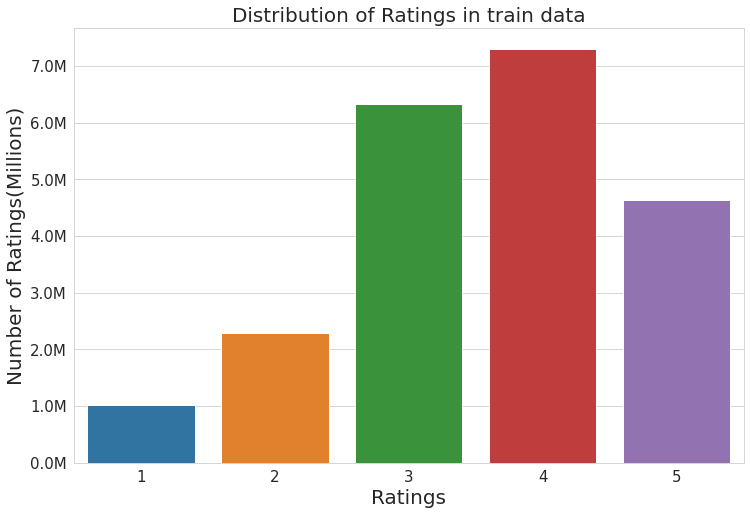

In [21]:
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="Ratings", data=Train_Data)

ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])

plt.tick_params(labelsize = 15)
plt.title("Distribution of Ratings in train data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings(Millions)", fontsize = 20)
plt.show()

In [22]:
Train_Data["DayOfWeek"] = Train_Data.Date.dt.weekday_name

In [23]:
Train_Data.tail()

,MovieID,CustID,Ratings,Date,DayOfWeek
21582067,8468,2626443,5,2005-08-07,Sunday
21582068,5496,1317762,3,2005-08-07,Sunday
21582069,5939,1300046,3,2005-08-07,Sunday
21582070,8980,1432514,4,2005-08-07,Sunday
21582071,7150,1618112,2,2005-08-07,Sunday


### Number of Ratings per month

/home/jadi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


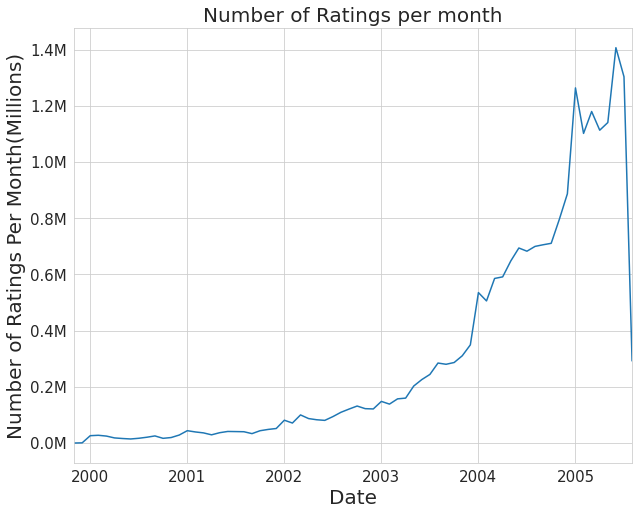

In [24]:
plt.figure(figsize = (10,8))
ax = Train_Data.resample("M", on = "Date")["Ratings"].count().plot()
#this above resample() function is a sort of group-by operation.Resample() function can work with dates. It can take months,
#days and years values independently. Here, in parameter we have given "M" which means it will group all the rows Monthly using 
#"Date" which is already present in the DataFrame. Now after grouping the rows month wise, we have just counted the ratings 
#which are grouped by months and plotted them. So, below plot shows that how many ratings are there per month. 
#In resample(), we can also give "6M" for grouping the rows every 6-Monthly, we can also give "Y" for grouping
#the rows yearly, we can also give "D" for grouping the rows by day.
#Resample() is a function which is designed to work with time and dates.
#This "Train_Data.resample("M", on = "Date")["Ratings"].count()" returns a pandas series where keys are Dates and values are 
#counts of ratings grouped by months.You can even check it and print it. Then we are plotting it, where it automatically takes
#Dates--which are keys on--x-axis and counts--which are values on--y-axis.
ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])
ax.set_title("Number of Ratings per month", fontsize = 20)
ax.set_xlabel("Date", fontsize = 20)
ax.set_ylabel("Number of Ratings Per Month(Millions)", fontsize = 20)
plt.tick_params(labelsize = 15)
plt.show()

In [25]:
#Train_Data.resample("M", on = "Date")["Ratings"].count()

### Analysis of Ratings given by user

In [26]:
no_of_rated_movies_per_user = Train_Data.groupby(by = "CustID")["Ratings"].count().sort_values(ascending = False)

In [27]:
no_of_rated_movies_per_user.head()

CustID
305344     4544
2439493    4165
387418     4098
1639792    2601
1461435    2484
Name: Ratings, dtype: int64

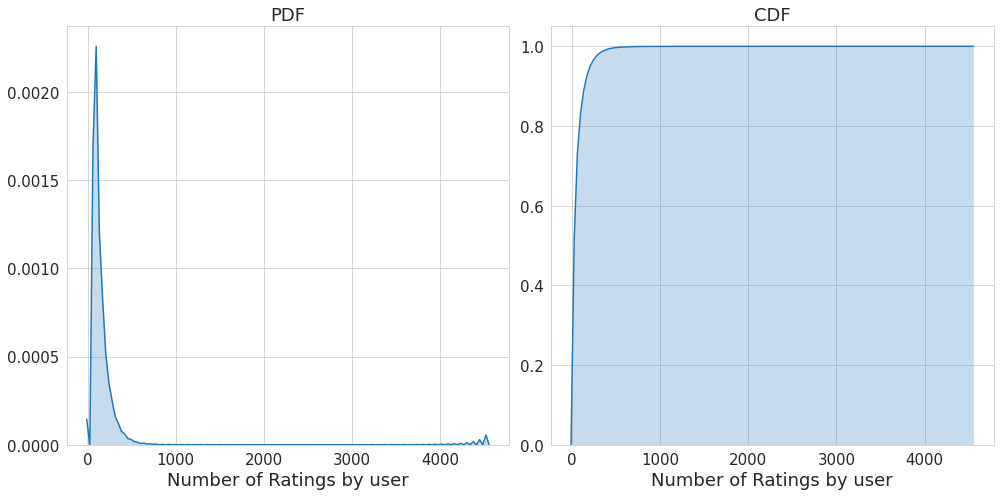

In [28]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(14,7))

sns.kdeplot(no_of_rated_movies_per_user.values, shade = True, ax = axes[0])
axes[0].set_title("PDF", fontsize = 18)
axes[0].set_xlabel("Number of Ratings by user", fontsize = 18)
axes[0].tick_params(labelsize = 15)

sns.kdeplot(no_of_rated_movies_per_user.values, shade = True, cumulative = True, ax = axes[1])
axes[1].set_title("CDF", fontsize = 18)
axes[1].set_xlabel("Number of Ratings by user", fontsize = 18)
axes[1].tick_params(labelsize = 15)

fig.subplots_adjust(wspace=2)
plt.tight_layout()
plt.show()

* Above PDF graph shows that almost all of the users give very few ratings. There are very few users who's ratings count is high.
* Similarly, above CDF graph shows that almost 99% of users give very few ratings.

In [29]:
print("Information about movie ratings grouped by users:")
no_of_rated_movies_per_user.describe()

Information about movie ratings grouped by users:


count    393933.000000
mean         54.786149
std          79.907844
min           1.000000
25%           9.000000
50%          25.000000
75%          68.000000
max        4544.000000
Name: Ratings, dtype: float64

In [30]:
# no_of_rated_movies_per_user.describe()["75%"]

In [31]:
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0,1.01,0.01))

/home/jadi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  


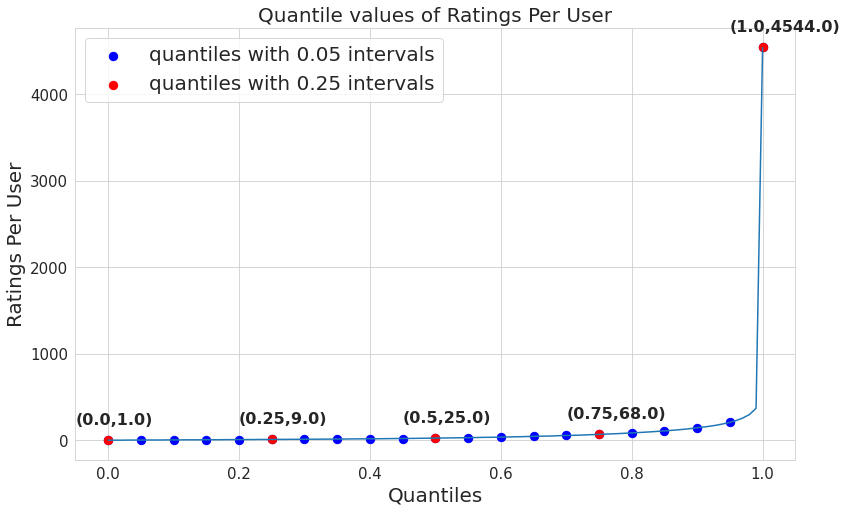

In [32]:
fig = plt.figure(figsize = (10, 6))

axes = fig.add_axes([0.1,0.1,1,1])
axes.set_title("Quantile values of Ratings Per User", fontsize = 20)
axes.set_xlabel("Quantiles", fontsize = 20)
axes.set_ylabel("Ratings Per User", fontsize = 20)
axes.plot(quantiles)

plt.scatter(x = quantiles.index[::5], y = quantiles.values[::5], c = "blue", s = 70, label="quantiles with 0.05 intervals")
plt.scatter(x = quantiles.index[::25], y = quantiles.values[::25], c = "red", s = 70, label="quantiles with 0.25 intervals")
plt.legend(loc='upper left', fontsize = 20)

for x, y in zip(quantiles.index[::25], quantiles.values[::25]):
    plt.annotate(s = '({},{})'.format(x, y), xy = (x, y), fontweight='bold', fontsize = 16, xytext=(x-0.05, y+180))
    
axes.tick_params(labelsize = 15)

In [33]:
quantiles[::5]

0.00       1.0
0.05       2.0
0.10       4.0
0.15       6.0
0.20       8.0
0.25       9.0
0.30      12.0
0.35      14.0
0.40      17.0
0.45      20.0
0.50      25.0
0.55      30.0
0.60      37.0
0.65      45.0
0.70      55.0
0.75      68.0
0.80      85.0
0.85     108.0
0.90     144.0
0.95     207.0
1.00    4544.0
Name: Ratings, dtype: float64

In [34]:
print("Total number of ratings below 75th percentile = "+str(sum(no_of_rated_movies_per_user.values<=133)))
print("Total number of ratings above 75th percentile = "+str(sum(no_of_rated_movies_per_user.values>133)))

Total number of ratings below 75th percentile = 349752
Total number of ratings above 75th percentile = 44181


### Analysis of Ratings Per Movie

In [35]:
no_of_ratings_per_movie = Train_Data.groupby(by = "MovieID")["Ratings"].count().sort_values(ascending = False)

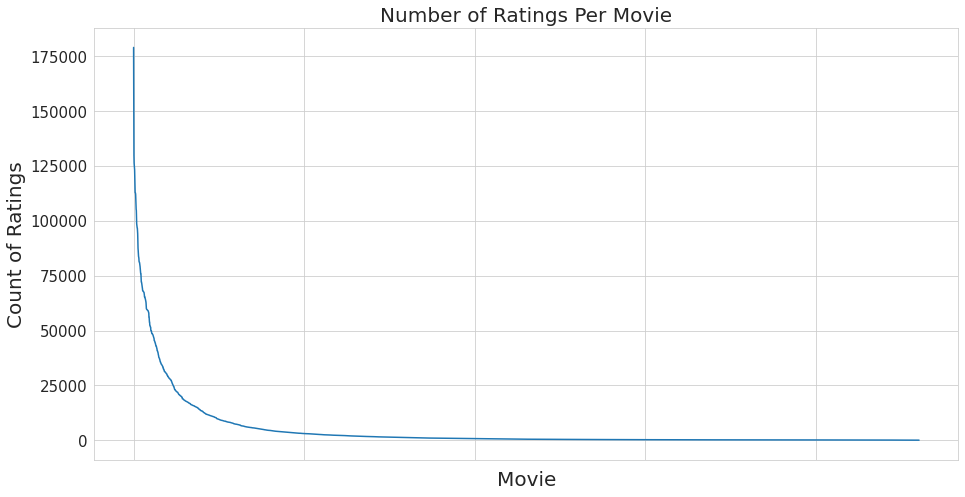

In [36]:
fig = plt.figure(figsize = (12, 6))
axes = fig.add_axes([0.1,0.1,1,1])
plt.title("Number of Ratings Per Movie", fontsize = 20)
plt.xlabel("Movie", fontsize = 20)
plt.ylabel("Count of Ratings", fontsize = 20)
plt.plot(no_of_ratings_per_movie.values)
plt.tick_params(labelsize = 15)
axes.set_xticklabels([])
plt.show()

<b>It is very skewed</b>
<p>It clearly shows that there are some movies which are very popular and were rated by many users as comapared to other movies</p>

### Analysis of Movie Ratings on Day of Week

/home/jadi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


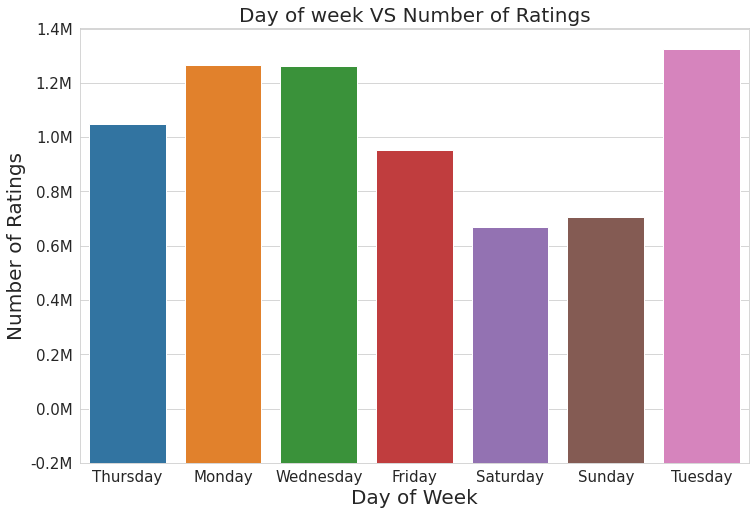

In [37]:
fig = plt.figure(figsize = (12, 8))

axes = sns.countplot(x = "DayOfWeek", data = Train_Data)
axes.set_title("Day of week VS Number of Ratings", fontsize = 20)
axes.set_xlabel("Day of Week", fontsize = 20)
axes.set_ylabel("Number of Ratings", fontsize = 20)
axes.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])
axes.tick_params(labelsize = 15)

plt.show()

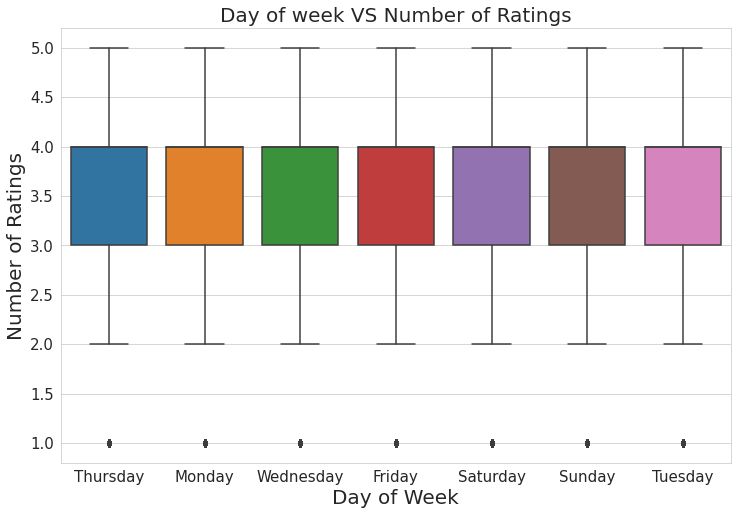

In [38]:
fig = plt.figure(figsize = (12, 8))

axes = sns.boxplot(x = "DayOfWeek", y = "Ratings", data = Train_Data)
axes.set_title("Day of week VS Number of Ratings", fontsize = 20)
axes.set_xlabel("Day of Week", fontsize = 20)
axes.set_ylabel("Number of Ratings", fontsize = 20)
axes.tick_params(labelsize = 15)

plt.show()

In [39]:
average_ratings_dayofweek = Train_Data.groupby(by = "DayOfWeek")["Ratings"].mean()
print("Average Ratings on Day of Weeks")
print(average_ratings_dayofweek)

Average Ratings on Day of Weeks
DayOfWeek
Friday       3.569771
Monday       3.561920
Saturday     3.582555
Sunday       3.579206
Thursday     3.567970
Tuesday      3.560549
Wednesday    3.570788
Name: Ratings, dtype: float64


## Creating USER-ITEM sparse matrix from data frame

In [40]:
startTime = datetime.now()
print("Creating USER_ITEM sparse matrix for train Data")
if os.path.isfile("/home/jadi/jadi/assignments/emaar/data1/movielens/TrainUISparseData.npz"):
    print("Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix")
    TrainUISparseData = sparse.load_npz("/home/jadi/jadi/assignments/emaar/data1/movielens/TrainUISparseData.npz")
    print("Shape of Train Sparse matrix = "+str(TrainUISparseData.shape))
    
else:
    print("We are creating sparse data")
    TrainUISparseData = sparse.csr_matrix((Train_Data.Ratings, (Train_Data.CustID, Train_Data.MovieID)))
    print("Creation done. Shape of sparse matrix = "+str(TrainUISparseData.shape))
    print("Saving it into disk for furthur usage.")
    sparse.save_npz("/home/jadi/jadi/assignments/emaar/data1/movielens/TrainUISparseData.npz", TrainUISparseData)
    print("Done\n")

print(datetime.now() - startTime)

Creating USER_ITEM sparse matrix for train Data
We are creating sparse data
Creation done. Shape of sparse matrix = (2649430, 9211)
Saving it into disk for furthur usage.
Done

0:00:14.345450


In [41]:
startTime = datetime.now()
print("Creating USER_ITEM sparse matrix for test Data")
if os.path.isfile("/home/jadi/jadi/assignments/emaar/data1/movielens/TestUISparseData.npz"):
    print("Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix")
    TestUISparseData = sparse.load_npz("/home/jadi/jadi/assignments/emaar/data1/movielens/TestUISparseData.npz")
    print("Shape of Test Sparse Matrix = "+str(TestUISparseData.shape))
else:
    print("We are creating sparse data")
    TestUISparseData = sparse.csr_matrix((Test_Data.Ratings, (Test_Data.CustID, Test_Data.MovieID)))
    print("Creation done. Shape of sparse matrix = "+str(TestUISparseData.shape))
    print("Saving it into disk for furthur usage.")
    sparse.save_npz("/home/jadi/jadi/assignments/emaar/data1/movielens/TestUISparseData.npz", TestUISparseData)
    print("Done\n")

print(datetime.now() - startTime)

Creating USER_ITEM sparse matrix for test Data
We are creating sparse data
Creation done. Shape of sparse matrix = (2649430, 9211)
Saving it into disk for furthur usage.
Done

0:00:04.079700


In [42]:
#If you can see above that the shape of both train and test sparse matrices are same, furthermore, how come this shape of sparse
#matrix has arrived:
#Shape of sparse matrix depends on highest value of User ID and highest value of Movie ID. 
#Now the user whose user ID is highest is present in both train data and test data. Similarly, the movie whose movie ID is
#highest is present in both train data and test data. Hence, shape of both train and test sparse matrices are same.

In [43]:
rows,cols = TrainUISparseData.shape
presentElements = TrainUISparseData.count_nonzero()

print("Sparsity Of Train matrix : {}% ".format((1-(presentElements/(rows*cols)))*100))

Sparsity Of Train matrix : 99.91156301968628% 


In [44]:
rows,cols = TestUISparseData.shape
presentElements = TestUISparseData.count_nonzero()

print("Sparsity Of Test matrix : {}% ".format((1-(presentElements/(rows*cols)))*100))

Sparsity Of Test matrix : 99.97789075082386% 


### Finding Global average of all movie ratings, Average rating per user, and Average rating per movie

In [45]:
def getAverageRatings(sparseMatrix, if_user):
    ax = 1 if if_user else 0
    #axis = 1 means rows and axis = 0 means columns 
    sumOfRatings = sparseMatrix.sum(axis = ax).A1  #this will give an array of sum of all the ratings of user if axis = 1 else 
    #sum of all the ratings of movies if axis = 0
    noOfRatings = (sparseMatrix!=0).sum(axis = ax).A1  #this will give a boolean True or False array, and True means 1 and False 
    #means 0, and further we are summing it to get the count of all the non-zero cells means length of non-zero cells
    rows, cols = sparseMatrix.shape
    averageRatings = {i: sumOfRatings[i]/noOfRatings[i] for i in range(rows if if_user else cols) if noOfRatings[i]!=0}
    return averageRatings

### Global Average Rating

In [46]:
Global_Average_Rating = TrainUISparseData.sum()/TrainUISparseData.count_nonzero()
print("Global Average Rating {}".format(Global_Average_Rating))

Global Average Rating 3.568994858325002


### Average Rating Per User

In [47]:
AvgRatingUser = getAverageRatings(TrainUISparseData, True)

In [132]:
# print("Average rating of user 25 = {}".format(AvgRatingUser[12]))

### Average Rating Per Movie

In [49]:
AvgRatingMovie = getAverageRatings(TrainUISparseData, False)

In [50]:
print("Average rating of movie 4500 = {}".format(AvgRatingMovie[4500]))

Average rating of movie 4500 = 3.2857142857142856


### PDF and CDF of Average Ratings of Users and Movies

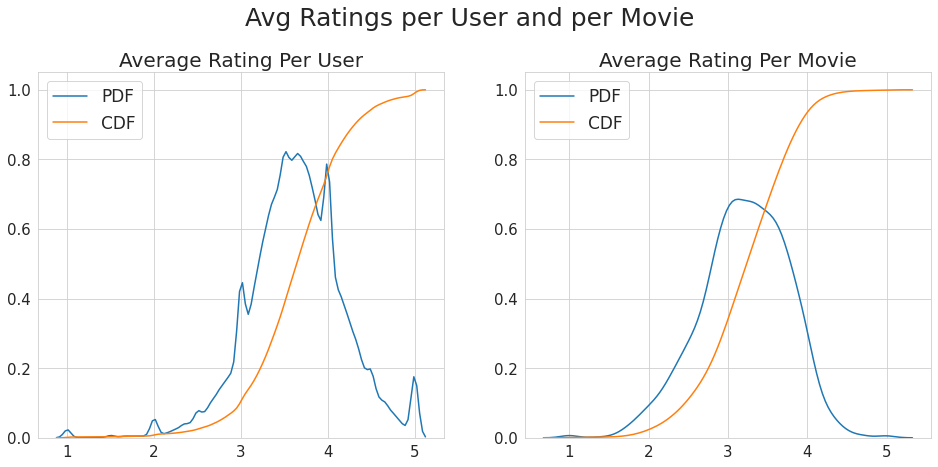

In [52]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 7))
fig.suptitle('Avg Ratings per User and per Movie', fontsize=25)

user_average = [rats for rats in AvgRatingUser.values()]
sns.distplot(user_average, hist = False, ax = axes[0], label = "PDF")
sns.kdeplot(user_average, cumulative = True, ax = axes[0], label = "CDF")
axes[0].set_title("Average Rating Per User", fontsize=20)
axes[0].tick_params(labelsize = 15)
axes[0].legend(loc='upper left', fontsize = 17)

movie_average = [ratm for ratm in AvgRatingMovie.values()]
sns.distplot(movie_average, hist = False, ax = axes[1], label = "PDF")
sns.kdeplot(movie_average, cumulative = True, ax = axes[1], label = "CDF")
axes[1].set_title("Average Rating Per Movie", fontsize=20)
axes[1].tick_params(labelsize = 15)
axes[1].legend(loc='upper left', fontsize = 17)

plt.subplots_adjust(wspace=0.2, top=0.85)
plt.show()

### Cold Start Problem

#### Cold Start Problem with Users

In [53]:
total_users = len(np.unique(Final_Data["CustID"]))
train_users = len(AvgRatingUser)
uncommonUsers = total_users - train_users
                  
print("Total number of Users = {}".format(total_users))
print("Number of Users in train data= {}".format(train_users))
print("Number of Users not present in train data = {}({}%)".format(uncommonUsers, np.round((uncommonUsers/total_users)*100), 2))

Total number of Users = 474062
Number of Users in train data= 393933
Number of Users not present in train data = 80129(17.0%)


#### Cold Start Problem with Movies

In [54]:
total_movies = len(np.unique(Final_Data["MovieID"]))
train_movies = len(AvgRatingMovie)
uncommonMovies = total_movies - train_movies
                  
print("Total number of Movies = {}".format(total_movies))
print("Number of Movies in train data= {}".format(train_movies))
print("Number of Movies not present in train data = {}({}%)".format(uncommonMovies, np.round((uncommonMovies/total_movies)*100), 2))

Total number of Movies = 4711
Number of Movies in train data= 4605
Number of Movies not present in train data = 106(2.0%)


## Computing Similarity Matrices

### Computing User-User Similarity Matrix

In [55]:
row_index, col_index = TrainUISparseData.nonzero()
rows = np.unique(row_index)
for i in rows[:10]:
    print(i)

6
7
10
33
42
59
79
83
87
94


In [56]:
#Here, we are calculating user-user similarity matrix only for first 100 users in our sparse matrix. And we are calculating 
#top 100 most similar users with them.
def getUser_UserSimilarity(sparseMatrix, top = 10):
    startTimestamp20 = datetime.now()  
    
    row_index, col_index = sparseMatrix.nonzero()  #this will give indices of rows in "row_index" and indices of columns in 
    #"col_index" where there is a non-zero value exist.
    rows = np.unique(row_index)
    similarMatrix = np.zeros(6170).reshape(617,10)    # 617*100 = 61700. As we are building similarity matrix only 
    #for top 10 most similar users.
    timeTaken = []
    howManyDone = 0
    for row in rows[:top]:
        howManyDone += 1
        startTimestamp = datetime.now().timestamp()  #it will give seconds elapsed
        sim = cosine_similarity(sparseMatrix.getrow(row), sparseMatrix).ravel()
        top10_similar_indices = sim.argsort()[-top:]
        top10_similar = sim[top10_similar_indices]
        similarMatrix[row] = top10_similar
        timeforOne = datetime.now().timestamp() - startTimestamp
        timeTaken.append(timeforOne)
        if howManyDone % 20 == 0:
            print("Time elapsed for {} users = {}sec".format(howManyDone, (datetime.now() - startTimestamp20)))
    print("Average Time taken to compute similarity matrix for 1 user = "+str(sum(timeTaken)/len(timeTaken))+"seconds")
    
    fig = plt.figure(figsize = (12,8))
    plt.plot(timeTaken, label = 'Time Taken For Each User')
    plt.plot(np.cumsum(timeTaken), label='Cumulative Time')
    plt.legend(loc='upper left', fontsize = 15)
    plt.xlabel('Users', fontsize = 20)
    plt.ylabel('Time(Seconds)', fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.show()
    
    return similarMatrix

Average Time taken to compute similarity matrix for 1 user = 0.9522257328033448seconds


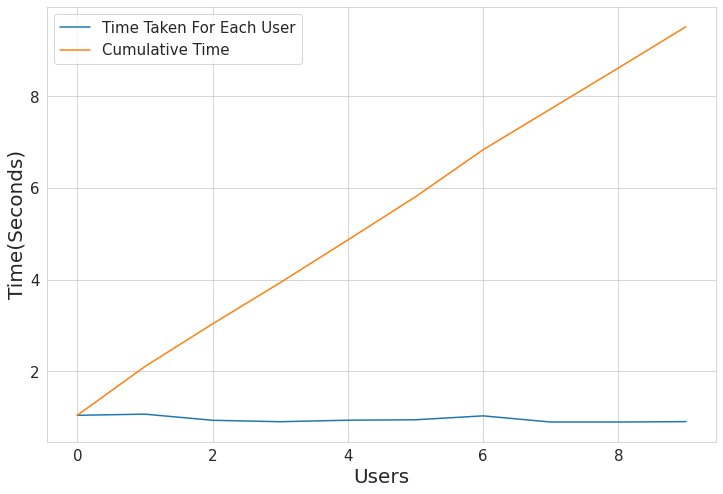

In [57]:
simMatrix = getUser_UserSimilarity(TrainUISparseData, 10)

### Computing Movie-Movie Similarity Matrix

In [58]:
start = datetime.now()

if not os.path.isfile("/home/jadi/jadi/assignments/emaar/data1/movielens/m_m_similarity.npz"):
    print("Movie-Movie Similarity file does not exist in your disk. Creating Movie-Movie Similarity Matrix...")
    
    m_m_similarity = cosine_similarity(TrainUISparseData.T, dense_output = False)
    print("Done")
    print("Dimension of Matrix = {}".format(m_m_similarity.shape))
    print("Storing the Movie Similarity matrix on disk for further usage")
    sparse.save_npz("/home/jadi/jadi/assignments/emaar/data1/movielens/m_m_similarity.npz", m_m_similarity)
else:
    print("File exists in the disk. Loading the file...")
    m_m_similarity = sparse.load_npz("/home/jadi/jadi/assignments/emaar/data1/movielens/m_m_similarity.npz")
    print("Dimension of Matrix = {}".format(m_m_similarity.shape))
    
print(datetime.now() - start)

Movie-Movie Similarity file does not exist in your disk. Creating Movie-Movie Similarity Matrix...
Done
Dimension of Matrix = (9211, 9211)
Storing the Movie Similarity matrix on disk for further usage
0:00:34.740795


### Does Movie-Movie Similarity Works?
### Let's pick random movie and check it's top 10 most similar movies.

In [59]:
movie_ids = np.unique(m_m_similarity.nonzero())

In [60]:
similar_movies_dict = dict()
for movie in movie_ids:
    smlr = np.argsort(-m_m_similarity[movie].toarray().ravel())[1:100]
    similar_movies_dict[movie] = smlr

In [62]:
movie_titles_df = pd.read_csv("/home/jadi/jadi/assignments/emaar/data1/movielens/movie_titles.csv",sep = ",", header = None, names=['MovieID', 'Year_of_Release', 'Movie_Title'], index_col = "MovieID", encoding = "iso8859_2")

In [63]:
movie_titles_df.head()

,Year_of_Release,Movie_Title
MovieID,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


### Similar Movies to: __Godzilla's Revenge__

In [65]:
movieID_GR = 4711

print("Name of the movie -------> "+str(movie_titles_df.loc[movieID_GR][1]))

print("Number of ratings by users for movie {} is {}".format(movie_titles_df.loc[movieID_GR][1], TrainUISparseData[:,movieID_GR].getnnz()))

print("Number of similar movies to {} is {}".format(movie_titles_df.loc[movieID_GR][1], m_m_similarity[movieID_GR].count_nonzero()))

Name of the movie -------> Journey Into Amazing Caves: IMAX
Number of ratings by users for movie Journey Into Amazing Caves: IMAX is 0
Number of similar movies to Journey Into Amazing Caves: IMAX is 0


In [66]:
# Meaning of "[:,17765]" means get all the values of column "17765".
# "getnnz()" give count of explicitly-stored values (nonzeros).

In [67]:
all_similar = sorted(m_m_similarity[movieID_GR].toarray().ravel(), reverse = True)[1:]

similar_100 = all_similar[:101]

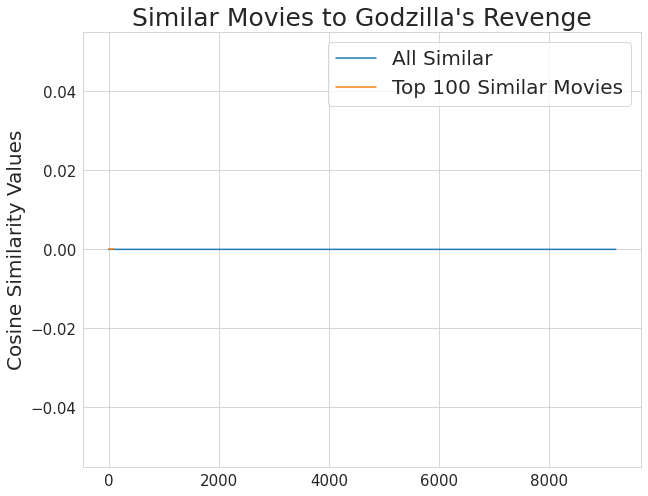

In [68]:
plt.figure(figsize = (10, 8))
plt.plot(all_similar, label = "All Similar")
plt.plot(similar_100, label = "Top 100 Similar Movies")
plt.title("Similar Movies to Godzilla's Revenge", fontsize = 25)
plt.ylabel("Cosine Similarity Values", fontsize = 20)
plt.tick_params(labelsize = 15)
plt.legend(fontsize = 20)
plt.show()

In [137]:
# movie_titles_df.loc[similar_movies_dict[movieID_GR][:10]]

## 5. Machine Learning Models

In [70]:
def get_sample_sparse_matrix(sparseMatrix, n_users, n_movies):
    startTime = datetime.now()
    users, movies, ratings = sparse.find(sparseMatrix)
    uniq_users = np.unique(users)
    uniq_movies = np.unique(movies)
    np.random.seed(15)   #this will give same random number everytime, without replacement
    userS = np.random.choice(uniq_users, n_users, replace = False)
    movieS = np.random.choice(uniq_movies, n_movies, replace = False)
    mask = np.logical_and(np.isin(users, userS), np.isin(movies, movieS))
    sparse_sample = sparse.csr_matrix((ratings[mask], (users[mask], movies[mask])), 
                                                     shape = (max(userS)+1, max(movieS)+1))
    print("Sparse Matrix creation done. Saving it for later use.")
    sparse.save_npz(path, sparse_sample)
    print("Done")
    print("Shape of Sparse Sampled Matrix = "+str(sparse_sample.shape))
    
    print(datetime.now() - start)
    return sparse_sample

### Creating Sample Sparse Matrix for Train Data

In [71]:
path = "/home/jadi/jadi/assignments/emaar/data1/movielens/TrainUISparseData_Sample.npz"
if not os.path.isfile(path):
    print("Sample sparse matrix is not present in the disk. We are creating it...")
    train_sample_sparse = get_sample_sparse_matrix(TrainUISparseData, 4000, 400)
else:
    print("File is already present in the disk. Loading the file...")
    train_sample_sparse = sparse.load_npz(path)
    print("File loading done.")
    print("Shape of Train Sample Sparse Matrix = "+str(train_sample_sparse.shape))

Sample sparse matrix is not present in the disk. We are creating it...
Sparse Matrix creation done. Saving it for later use.
Done
Shape of Sparse Sampled Matrix = (2649060, 9210)
0:09:04.480929


### Creating Sample Sparse Matrix for Test Data

In [72]:
path = "/home/jadi/jadi/assignments/emaar/data1/movielens/TestUISparseData_Sample.npz"
if not os.path.isfile(path):
    print("Sample sparse matrix is not present in the disk. We are creating it...")
    test_sample_sparse = get_sample_sparse_matrix(TestUISparseData, 2000, 200)
else:
    print("File is already present in the disk. Loading the file...")
    test_sample_sparse = sparse.load_npz(path)
    print("File loading done.")
    print("Shape of Test Sample Sparse Matrix = "+str(test_sample_sparse.shape))

Sample sparse matrix is not present in the disk. We are creating it...
Sparse Matrix creation done. Saving it for later use.
Done
Shape of Sparse Sampled Matrix = (2648369, 9211)
0:09:13.499959


### Finding Global Average of all movie ratings, Average rating per User, and Average rating per Movie (from sampled train)

In [73]:
print("Global average of all movies ratings in Train Sample Sparse is {}".format(np.round((train_sample_sparse.sum()/train_sample_sparse.count_nonzero()), 2)))

Global average of all movies ratings in Train Sample Sparse is 3.69


### Featurizing data

In [76]:
print("No of ratings in Our Sampled train matrix is : {}".format(train_sample_sparse.count_nonzero()))
print("No of ratings in Our Sampled test matrix is : {}".format(test_sample_sparse.count_nonzero()))

No of ratings in Our Sampled train matrix is : 22280
No of ratings in Our Sampled test matrix is : 1204


### Featurizing data for regression problem

### Featurizing Train Data

In [77]:
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(train_sample_sparse)

In [78]:
if os.path.isfile("/home/jadi/jadi/assignments/emaar/data1/movielens/Train_Regression.csv"):
    print("File is already present in your disk. You do not have to prepare it again.")
else:
    startTime = datetime.now()
    print("Preparing Train csv file for {} rows".format(len(sample_train_ratings)))
    with open("/home/jadi/jadi/assignments/emaar/data1/movielens/Train_Regression.csv", mode = "w") as data:
        count = 0
        for user, movie, rating in zip(sample_train_users, sample_train_movies, sample_train_ratings):
            row = list()
            row.append(user)  #appending user ID
            row.append(movie) #appending movie ID
            row.append(train_sample_sparse.sum()/train_sample_sparse.count_nonzero()) #appending global average rating

#----------------------------------Ratings given to "movie" by top 5 similar users with "user"--------------------#
            similar_users = cosine_similarity(train_sample_sparse[user], train_sample_sparse).ravel()
            similar_users_indices = np.argsort(-similar_users)[1:]
            similar_users_ratings = train_sample_sparse[similar_users_indices, movie].toarray().ravel()
            top_similar_user_ratings = list(similar_users_ratings[similar_users_ratings != 0][:5])
            top_similar_user_ratings.extend([globalAvgMovies[movie]]*(5-len(top_similar_user_ratings)))
            #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "movie" average
            #rating. Let say only 3 out of 5 ratings are available then rest 2 will be "movie" average rating.
            row.extend(top_similar_user_ratings)
            
 #----------------------------------Ratings given by "user" to top 5 similar movies with "movie"------------------#
            similar_movies = cosine_similarity(train_sample_sparse[:,movie].T, train_sample_sparse.T).ravel()
            similar_movies_indices = np.argsort(-similar_movies)[1:]
            similar_movies_ratings = train_sample_sparse[user, similar_movies_indices].toarray().ravel()
            top_similar_movie_ratings = list(similar_movies_ratings[similar_movies_ratings != 0][:5])
            top_similar_movie_ratings.extend([globalAvgUsers[user]]*(5-len(top_similar_movie_ratings)))
            #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "user" average
            #rating. Let say only 3 out of 5 ratings are available then rest 2 will be "user" average rating.
            row.extend(top_similar_movie_ratings)
            
 #----------------------------------Appending "user" average, "movie" average & rating of "user""movie"-----------#
            row.append(globalAvgUsers[user])
            row.append(globalAvgMovies[movie])
            row.append(rating)
            
#-----------------------------------Converting rows and appending them as comma separated values to csv file------#
            data.write(",".join(map(str, row)))
            data.write("\n")
    
            count += 1
            if count % 2000 == 0:
                print("Done for {}. Time elapsed: {}".format(count, (datetime.now() - startTime)))
                
    print("Total Time for {} rows = {}".format(len(sample_train_ratings), (datetime.now() - startTime)))

Preparing Train csv file for 22280 rows
Done for 2000. Time elapsed: 0:04:45.671952
Done for 4000. Time elapsed: 0:09:40.175027
Done for 6000. Time elapsed: 0:14:38.975445
Done for 8000. Time elapsed: 0:18:06.383263
Done for 10000. Time elapsed: 0:21:32.118767
Done for 12000. Time elapsed: 0:25:02.507497
Done for 14000. Time elapsed: 0:28:29.846996
Done for 16000. Time elapsed: 0:31:54.563815
Done for 18000. Time elapsed: 0:35:27.737539
Done for 20000. Time elapsed: 0:38:59.670203
Done for 22000. Time elapsed: 0:42:37.402044
Total Time for 22280 rows = 0:43:06.936208


In [79]:
Train_Reg = pd.read_csv("/home/jadi/jadi/assignments/emaar/data1/movielens/Train_Regression.csv", names = ["User_ID", "Movie_ID", "Global_Average", "SUR1", "SUR2", "SUR3", "SUR4", "SUR5", "SMR1", "SMR2", "SMR3", "SMR4", "SMR5", "User_Average", "Movie_Average", "Rating"])
Train_Reg.head()

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,User_Average,Movie_Average,Rating
0,17451,4515,3.686311,4.0,3.0,5.0,3.0,3.0,5.0,3.0,5.0,5.0,5.0,4.777778,3.45,5
1,97289,4515,3.686311,3.0,3.0,4.0,3.0,3.0,4.0,3.0,3.0,4.0,4.0,3.769231,3.45,4
2,167410,4515,3.686311,3.0,4.0,5.0,3.0,3.0,4.0,2.0,4.0,3.0,3.0,3.484848,3.45,3
3,258319,4515,3.686311,3.0,5.0,3.0,3.0,4.0,3.0,4.0,3.0,3.0,3.0,3.233333,3.45,3
4,473233,4515,3.686311,3.0,5.0,3.0,4.0,3.0,5.0,5.0,4.0,3.0,4.0,4.114286,3.45,5


In [80]:
print("Number of nan Values = "+str(Train_Reg.isnull().sum().sum()))

Number of nan Values = 0


In [81]:
print("Shape of Train DataFrame = {}".format(Train_Reg.shape))

Shape of Train DataFrame = (22280, 16)


### Featurizing Test Data

In [82]:
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(test_sample_sparse)

In [83]:
if os.path.isfile("/home/jadi/jadi/assignments/emaar/data1/movielens/Test_Regression.csv"):
    print("File is already present in your disk. You do not have to prepare it again.")
else:
    startTime = datetime.now()
    print("Preparing Test csv file for {} rows".format(len(sample_test_ratings)))
    with open("/home/jadi/jadi/assignments/emaar/data1/movielens/Test_Regression.csv", mode = "w") as data:
        count = 0
        for user, movie, rating in zip(sample_test_users, sample_test_movies, sample_test_ratings):
            row = list()
            row.append(user)  #appending user ID
            row.append(movie) #appending movie ID
            row.append(train_sample_sparse.sum()/train_sample_sparse.count_nonzero()) #appending global average rating

#-----------------------------Ratings given to "movie" by top 5 similar users with "user"-------------------------#
            try:
                similar_users = cosine_similarity(train_sample_sparse[user], train_sample_sparse).ravel()
                similar_users_indices = np.argsort(-similar_users)[1:]
                similar_users_ratings = train_sample_sparse[similar_users_indices, movie].toarray().ravel()
                top_similar_user_ratings = list(similar_users_ratings[similar_users_ratings != 0][:5])
                top_similar_user_ratings.extend([globalAvgMovies[movie]]*(5-len(top_similar_user_ratings)))
                #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "movie" 
                #average rating. Let say only 3 out of 5 ratings are available then rest 2 will be "movie" average rating.
                row.extend(top_similar_user_ratings)
            #########Cold Start Problem, for a new user or a new movie#########    
            except(IndexError, KeyError):
                global_average_train_rating = [train_sample_sparse.sum()/train_sample_sparse.count_nonzero()]*5
                row.extend(global_average_train_rating)
            except:
                raise
                
 #-----------------------------Ratings given by "user" to top 5 similar movies with "movie"-----------------------#
            try:
                similar_movies = cosine_similarity(train_sample_sparse[:,movie].T, train_sample_sparse.T).ravel()
                similar_movies_indices = np.argsort(-similar_movies)[1:]
                similar_movies_ratings = train_sample_sparse[user, similar_movies_indices].toarray().ravel()
                top_similar_movie_ratings = list(similar_movies_ratings[similar_movies_ratings != 0][:5])
                top_similar_movie_ratings.extend([globalAvgUsers[user]]*(5-len(top_similar_movie_ratings)))
                #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "user" 
                #average rating. Let say only 3 out of 5 ratings are available then rest 2 will be "user" average rating.
                row.extend(top_similar_movie_ratings)
            #########Cold Start Problem, for a new user or a new movie#########
            except(IndexError, KeyError):
                global_average_train_rating = [train_sample_sparse.sum()/train_sample_sparse.count_nonzero()]*5
                row.extend(global_average_train_rating)
            except:
                raise
                
 #-----------------------------Appending "user" average, "movie" average & rating of "user""movie"----------------#
            try:        
                row.append(globalAvgUsers[user])
            except (KeyError):
                global_average_train_rating = train_sample_sparse.sum()/train_sample_sparse.count_nonzero()
                row.append(global_average_train_rating)
            except:
                raise
                
            try:
                row.append(globalAvgMovies[movie])
            except(KeyError):
                global_average_train_rating = train_sample_sparse.sum()/train_sample_sparse.count_nonzero()
                row.append(global_average_train_rating)
            except:
                raise
                
            row.append(rating)
            
#------------------------------Converting rows and appending them as comma separated values to csv file-----------#
            data.write(",".join(map(str, row)))
            data.write("\n")
    
            count += 1
            if count % 100 == 0:
                print("Done for {}. Time elapsed: {}".format(count, (datetime.now() - startTime)))
                
    print("Total Time for {} rows = {}".format(len(sample_test_ratings), (datetime.now() - startTime)))

Preparing Test csv file for 1204 rows
Done for 100. Time elapsed: 0:00:12.301119
Done for 200. Time elapsed: 0:00:24.685716
Done for 300. Time elapsed: 0:00:36.795873
Done for 400. Time elapsed: 0:00:49.229432
Done for 500. Time elapsed: 0:01:01.476747
Done for 600. Time elapsed: 0:01:13.706054
Done for 700. Time elapsed: 0:01:26.006461
Done for 800. Time elapsed: 0:01:38.222093
Done for 900. Time elapsed: 0:01:50.673902
Done for 1000. Time elapsed: 0:02:02.824392
Done for 1100. Time elapsed: 0:02:15.195327
Done for 1200. Time elapsed: 0:02:27.662608
Total Time for 1204 rows = 0:02:28.077577


In [84]:
Test_Reg = pd.read_csv("/home/jadi/jadi/assignments/emaar/data1/movielens/Test_Regression.csv", names = ["User_ID", "Movie_ID", "Global_Average", "SUR1", "SUR2", "SUR3", "SUR4", "SUR5", "SMR1", "SMR2", "SMR3", "SMR4", "SMR5", "User_Average", "Movie_Average", "Rating"])
Test_Reg.head()

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,User_Average,Movie_Average,Rating
0,2318884,4504,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3
1,331860,4564,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,4
2,67209,4570,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3
3,67626,4570,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3
4,141921,4570,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,1


In [85]:
print("Number of nan Values = "+str(Test_Reg.isnull().sum().sum()))

Number of nan Values = 0


In [86]:
print("Shape of Test DataFrame = {}".format(Test_Reg.shape))

Shape of Test DataFrame = (1204, 16)


### Transforming Data for Surprise Models

In [87]:
Train_Reg[['User_ID', 'Movie_ID', 'Rating']].head(5)

,User_ID,Movie_ID,Rating
0,17451,4515,5
1,97289,4515,4
2,167410,4515,3
3,258319,4515,3
4,473233,4515,5


In [88]:
reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(Train_Reg[['User_ID', 'Movie_ID', 'Rating']], reader)

trainset = data.build_full_trainset()

In [89]:
testset = list(zip(Test_Reg["User_ID"].values, Test_Reg["Movie_ID"].values, Test_Reg["Rating"].values))

In [90]:
testset[:5]

[(2318884, 4504, 3),
 (331860, 4564, 4),
 (67209, 4570, 3),
 (67626, 4570, 3),
 (141921, 4570, 1)]

### Applying Machine Learning Models

In [91]:
error_table = pd.DataFrame(columns = ["Model", "Train RMSE", "Train MAPE", "Test RMSE", "Test MAPE"])
model_train_evaluation = dict()
model_test_evaluation = dict()

In [92]:
def make_table(model_name, rmse_train, mape_train, rmse_test, mape_test):
    global error_table
    #All variable assignments in a function store the value in the local symbol table; whereas variable references first look 
    #in the local symbol table, then in the global symbol table, and then in the table of built-in names. Thus, global variables 
    #cannot be directly assigned a value within a function (unless named in a global statement), 
    #although they may be referenced.
    error_table = error_table.append(pd.DataFrame([[model_name, rmse_train, mape_train, rmse_test, mape_test]], columns = ["Model", "Train RMSE", "Train MAPE", "Test RMSE", "Test MAPE"]))
    error_table.reset_index(drop = True, inplace = True)

### Utility Functions for Regression Models

In [93]:
def error_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(abs((y_true - y_pred)/y_true))*100
    return rmse, mape

In [94]:
def train_test_xgboost(x_train, x_test, y_train, y_test, model_name):
    startTime = datetime.now()
    train_result = dict()
    test_result = dict()
    
    clf = xgb.XGBRegressor(n_estimators = 100, silent = False, n_jobs  = 10)
    clf.fit(x_train, y_train)
    
    print("-"*50)
    print("TRAIN DATA")
    y_pred_train = clf.predict(x_train)
    rmse_train, mape_train = error_metrics(y_train, y_pred_train)
    print("RMSE = {}".format(rmse_train))
    print("MAPE = {}".format(mape_train))
    print("-"*50)
    train_result = {"RMSE": rmse_train, "MAPE": mape_train, "Prediction": y_pred_train}
    
    print("TEST DATA")
    y_pred_test = clf.predict(x_test)
    rmse_test, mape_test = error_metrics(y_test, y_pred_test)
    print("RMSE = {}".format(rmse_test))
    print("MAPE = {}".format(mape_test))
    print("-"*50)
    test_result = {"RMSE": rmse_test, "MAPE": mape_test, "Prediction": y_pred_test}
        
    print("Time Taken = "+str(datetime.now() - startTime))
    
    plot_importance(xgb, clf)
    
    make_table(model_name, rmse_train, mape_train, rmse_test, mape_test)
    
    return train_result, test_result

In [95]:
def plot_importance(model, clf):
    fig = plt.figure(figsize = (8, 6))
    ax = fig.add_axes([0,0,1,1])
    model.plot_importance(clf, ax = ax, height = 0.3)
    plt.xlabel("F Score", fontsize = 20)
    plt.ylabel("Features", fontsize = 20)
    plt.title("Feature Importance", fontsize = 20)
    plt.tick_params(labelsize = 15)
    
    plt.show()

### Utility Functions for Surprise Models

In [96]:
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    predicted = np.array([pred.est for pred in predictions])
    return actual, predicted
#in surprise prediction of every data point is returned as dictionary like this:
#"user: 196        item: 302        r_ui = 4.00   est = 4.06   {'actual_k': 40, 'was_impossible': False}"
#In this dictionary, "r_ui" is a key for actual rating and "est" is a key for predicted rating 

In [97]:
def get_error(predictions):
    actual, predicted = get_ratings(predictions)
    rmse = np.sqrt(mean_squared_error(actual, predicted)) 
    mape = np.mean(abs((actual - predicted)/actual))*100
    return rmse, mape

In [98]:
my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

def run_surprise(algo, trainset, testset, model_name):
    startTime = datetime.now()
    
    train = dict()
    test = dict()
    
    algo.fit(trainset)
    #You can check out above function at "https://surprise.readthedocs.io/en/stable/getting_started.html" in 
    #"Train-test split and the fit() method" section
    
#-----------------Evaluating Train Data------------------#
    print("-"*50)
    print("TRAIN DATA")
    train_pred = algo.test(trainset.build_testset())
    #You can check out "algo.test()" function at "https://surprise.readthedocs.io/en/stable/getting_started.html" in 
    #"Train-test split and the fit() method" section
    #You can check out "trainset.build_testset()" function at "https://surprise.readthedocs.io/en/stable/FAQ.html#can-i-use-my-own-dataset-with-surprise-and-can-it-be-a-pandas-dataframe" in 
    #"How to get accuracy measures on the training set" section
    train_actual, train_predicted = get_ratings(train_pred)
    train_rmse, train_mape = get_error(train_pred)
    print("RMSE = {}".format(train_rmse))
    print("MAPE = {}".format(train_mape))
    print("-"*50)
    train = {"RMSE": train_rmse, "MAPE": train_mape, "Prediction": train_predicted}
    
#-----------------Evaluating Test Data------------------#
    print("TEST DATA")
    test_pred = algo.test(testset)
    #You can check out "algo.test()" function at "https://surprise.readthedocs.io/en/stable/getting_started.html" in 
    #"Train-test split and the fit() method" section
    test_actual, test_predicted = get_ratings(test_pred)
    test_rmse, test_mape = get_error(test_pred)
    print("RMSE = {}".format(test_rmse))
    print("MAPE = {}".format(test_mape))
    print("-"*50)
    test = {"RMSE": test_rmse, "MAPE": test_mape, "Prediction": test_predicted}
    
    print("Time Taken = "+str(datetime.now() - startTime))
    
    make_table(model_name, train_rmse, train_mape, test_rmse, test_mape)
    
    return train, test

## 1. XGBoost Features

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[15:04:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
--------------------------------------------------
TRAIN DATA
RMSE = 0.8019894048749562
MAPE = 22.746844589710236
--------------------------------------------------
TEST DATA
RMSE = 1.0434460531319678
MAPE = 31.22794470880756
--------------------------------------------------
Time Taken = 0:00:01.906184


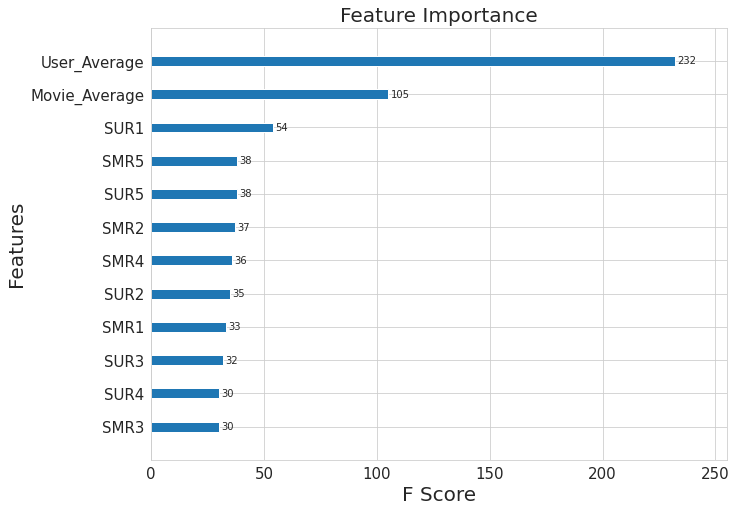

In [99]:
x_train = Train_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

x_test = Test_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

y_train = Train_Reg["Rating"]

y_test = Test_Reg["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGBoost_13")

model_train_evaluation["XGBoost_13"] = train_result
model_test_evaluation["XGBoost_13"] = test_result

### Adding predicted ratings from Surprise BaselineOnly model to our Train and Test Dataframe

In [101]:
Train_Reg["BaselineOnly"] = model_train_evaluation["BaselineOnly"]["Prediction"]

In [102]:
Train_Reg.head()

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,User_Average,Movie_Average,Rating,BaselineOnly
0,17451,4515,3.686311,4.0,3.0,5.0,3.0,3.0,5.0,3.0,5.0,5.0,5.0,4.777778,3.45,5,4.722612
1,97289,4515,3.686311,3.0,3.0,4.0,3.0,3.0,4.0,3.0,3.0,4.0,4.0,3.769231,3.45,4,4.503600
2,167410,4515,3.686311,3.0,4.0,5.0,3.0,3.0,4.0,2.0,4.0,3.0,3.0,3.484848,3.45,3,4.554201
3,258319,4515,3.686311,3.0,5.0,3.0,3.0,4.0,3.0,4.0,3.0,3.0,3.0,3.233333,3.45,3,4.453987
4,473233,4515,3.686311,3.0,5.0,3.0,4.0,3.0,5.0,5.0,4.0,3.0,4.0,4.114286,3.45,5,4.705385


In [103]:
print("Number of nan values = "+str(Train_Reg.isnull().sum().sum()))

Number of nan values = 0


In [104]:
Test_Reg["BaselineOnly"] = model_test_evaluation["BaselineOnly"]["Prediction"]
Test_Reg.head()

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,User_Average,Movie_Average,Rating,BaselineOnly
0,2318884,4504,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3,3.686311
1,331860,4564,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,4,3.686311
2,67209,4570,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3,3.686311
3,67626,4570,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3,3.686311
4,141921,4570,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,3.686311,1,3.686311


In [105]:
print("Number of nan values = "+str(Test_Reg.isnull().sum().sum()))

Number of nan values = 0


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[15:04:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
--------------------------------------------------
TRAIN DATA
RMSE = 0.8017754972462935
MAPE = 22.743505239486694
--------------------------------------------------
TEST DATA
RMSE = 1.0431179801955286
MAPE = 31.23437034001273
--------------------------------------------------
Time Taken = 0:00:00.283796


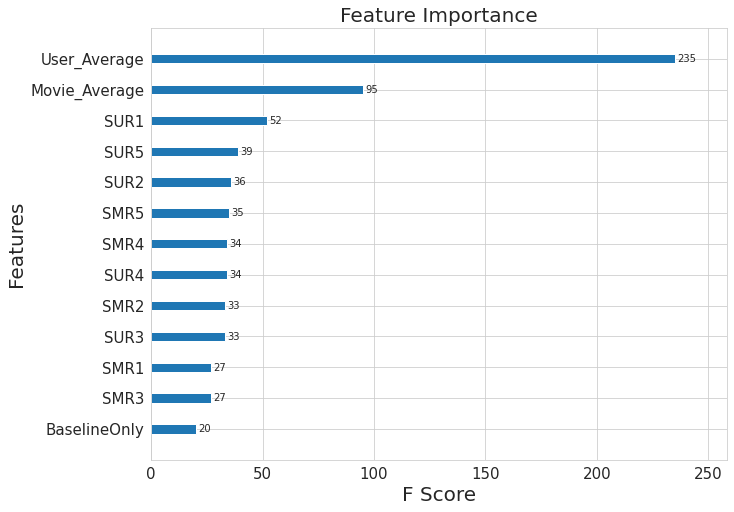

In [106]:
x_train = Train_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

x_test = Test_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

y_train = Train_Reg["Rating"]

y_test = Test_Reg["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL")

model_train_evaluation["XGB_BSL"] = train_result
model_test_evaluation["XGB_BSL"] = test_result